In [1]:
!pip install -q mplfinance

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix

import mplfinance as mplf

In [3]:
np.__version__, pd.__version__, tf.__version__, keras.__version__, sklearn.__version__, mplf.__version__

('1.20.3', '1.3.5', '2.6.2', '2.6.0', '0.23.2', '0.12.8b9')

In [4]:
SEED = 1291

In [5]:
ohlc = pd.read_csv("../input/candle-stick-patterns/ohlc.csv", index_col=0, parse_dates=True)
print(ohlc.shape)
ohlc[:3]

data_df = pd.read_pickle("../input/candlestick-eda/data_df.pkl")
data_df = data_df.sort_values("imgID").reset_index(drop=True)
print(data_df.shape)
data_df[:3]

Data_Size = data_df.shape[0]


(116667, 4)
(36724, 3)


In [6]:
data_df = pd.concat([ohlc.reset_index(drop=True)[:Data_Size],data_df],1)
print(data_df.shape)
data_df[:3]

(36724, 7)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


,open,high,low,close,file_path,imgID,imgData
0,3230.0,3240.0,3225.0,3232.0,../input/candle-stick-patterns/cs3_0.png,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,3234.0,3236.5,3221.5,3221.5,../input/candle-stick-patterns/cs3_1.png,1,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
2,3226.5,3228.0,3220.0,3228.0,../input/candle-stick-patterns/cs3_2.png,2,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


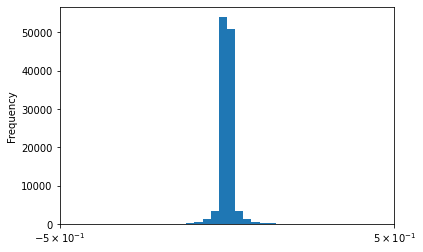

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
(-0.56, -0.0101]        14583
(-0.0024, -6.41e-05]    14583
(-0.0101, -0.00518]     14582
(-0.00518, -0.0024]     14582
(0.0023, 0.00515]       14582
(0.00515, 0.0102]       14582
(0.0102, 2.357]         14582
(-6.41e-05, 0.0023]     14581
Name: high, dtype: int64


{Interval(-0.56, -0.0101, closed='right'): 0,
 Interval(-0.0101, -0.00518, closed='right'): 1,
 Interval(-0.00518, -0.0024, closed='right'): 2,
 Interval(-0.0024, -6.41e-05, closed='right'): 3,
 Interval(-6.41e-05, 0.0023, closed='right'): 4,
 Interval(0.0023, 0.00515, closed='right'): 5,
 Interval(0.00515, 0.0102, closed='right'): 6,
 Interval(0.0102, 2.357, closed='right'): 7}

In [7]:
# preparing labels to forecast rise on next 3rd bar
# window = size 5 with center labeled <--|-->, so have to shift (5-1)/2 = 3 

NBars = 3
window_size = 5
targetBarPos = 3


pct_changes = ((ohlc["high"].shift(-(targetBarPos+NBars)).rolling(window_size, center=True).mean() - ohlc["high"])/ohlc["high"])
pct_changes.plot(kind="hist", bins=120)
plt.xlim(-0.5,0.5)
plt.xscale("symlog")
plt.show()

# categorize ranges of change
qsize = 0.125
qs = np.arange(0,1+qsize,qsize)
qranges = pd.qcut(pct_changes, q = qs)
print(qs)
print(qranges.value_counts())

# use top ranges as 1 and others as 0
data_df["h_labels"] = qranges.cat.codes.values[:Data_Size]
data_df["ts"] = qranges.index[:Data_Size]
data_df = data_df.set_index("ts")
data_df["h_labels"] = data_df["h_labels"].map({
    7:1, 6:1, 
    0:2, 1:2
})
data_df["h_labels"] = data_df["h_labels"].fillna(0) # should drop -1 first, not handled here

dict(
    zip(
        qranges.cat.categories, 
        range(len(qranges.cat.categories))
    )
)
# -1 for nan's

In [8]:
data_df.head(10)

,open,high,low,close,file_path,imgID,imgData,h_labels
ts,,,,,,,,
2020-01-01 00:00:00,3230.0,3240.0,3225.0,3232.0,../input/candle-stick-patterns/cs3_0.png,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0.0
2020-01-01 12:00:00,3234.0,3236.5,3221.5,3221.5,../input/candle-stick-patterns/cs3_1.png,1,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0.0
2020-01-02 00:00:00,3226.5,3228.0,3220.0,3228.0,../input/candle-stick-patterns/cs3_2.png,2,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",2.0
2020-01-02 12:00:00,3229.0,3243.5,3229.0,3231.5,../input/candle-stick-patterns/cs3_3.png,3,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",2.0
2020-01-03 00:00:00,3233.0,3234.5,3217.0,3219.5,../input/candle-stick-patterns/cs3_4.png,4,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",2.0
2020-01-03 12:00:00,3221.0,3223.0,3208.0,3213.5,../input/candle-stick-patterns/cs3_5.png,5,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0.0
2020-01-04 00:00:00,3215.5,3216.5,3208.5,3209.5,../input/candle-stick-patterns/cs3_6.png,6,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0.0
2020-01-04 12:00:00,3210.5,3210.5,3200.0,3201.0,../input/candle-stick-patterns/cs3_7.png,7,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",0.0
2020-01-05 00:00:00,3196.0,3202.5,3191.5,3200.5,../input/candle-stick-patterns/cs3_8.png,8,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1.0


# Prep X, y

In [9]:
X = data_df.sort_values("imgID")["imgData"].apply(lambda x: x.reshape(1,40,40,1))
X = np.concatenate(X.values)
X.shape

y = data_df["h_labels"]

In [10]:
y.value_counts() # 1: buy, 2: sell

0.0    21681
1.0     7645
2.0     7398
Name: h_labels, dtype: int64

In [11]:
class_weights = (y.astype(int).value_counts().max() / y.astype(int).value_counts()).to_dict()
class_weights

{0: 1.0, 1: 2.8359712230215828, 2: 2.9306569343065694}

# Split Data

In [12]:
X.shape

(36724, 40, 40, 1)

In [13]:
tss = TimeSeriesSplit(n_splits=2)
for train_idx, test_idx in tss.split(X,y):
    break

X_tr, X_ts = X[train_idx], X[test_idx]
y_tr, y_ts = keras.utils.to_categorical(y[train_idx]), keras.utils.to_categorical(y[test_idx])

[x.shape for x in [X_tr, X_ts, y_tr, y_ts]]

[(12242, 40, 40, 1), (12241, 40, 40, 1), (12242, 3), (12241, 3)]

In [14]:
keras.backend.clear_session()
model = keras.models.load_model('../input/candle-stick-autoencoder/best_model.ckp')
# model.summary()
encoder = keras.models.Sequential(model.layers[:15])
encoder.compile(optimizer="adam", loss='binary_crossentropy')

for layer in encoder.layers: layer.trainable = False
encoder.summary()

2022-02-19 07:42:40.465936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 07:42:40.560307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 07:42:40.561024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 07:42:40.562262: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 16)        80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 16)        2

In [15]:
def define_model():
    clf = keras.models.Sequential(encoder.layers + 
                                 [
                                     layers.Flatten(),
                                     layers.Dense(256, activation="relu", name="dense_clf"),
                                     layers.BatchNormalization(trainable=False, name="bn1"),
                                     layers.Dropout(0.3, name="drop_clf1"),
                                     layers.Dense(128, activation="relu", name="dense_clf_1"),
                                     layers.BatchNormalization(trainable=False, name="bn2"),
                                     layers.Dropout(0.3, name="drop_clf2"),
                                     layers.Dense(64, activation="relu", name="dense_clf_2"),
                                     layers.BatchNormalization(trainable=False, name="bn3"),
                                     layers.Dropout(0.3, name="drop_clf3"),
                                     layers.Dense(12, activation="relu", name="dense_clf_3"),
                                     layers.Dense(3, activation="softmax", name="dense_clf_4"),
                                 ])
    adam = keras.optimizers.Adam(learning_rate=0.001)
    clf.compile(optimizer=adam, loss='binary_crossentropy')
    clf.build(input_shape=(128,40,40,1))
    return clf

clf = define_model()    
clf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  80        
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  64        
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  2320      
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                 

In [16]:
np.random.seed(1291)

clf = define_model()


es = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=15,
    verbose=1,
    mode='auto',
    restore_best_weights=True)
ckp = keras.callbacks.ModelCheckpoint(
    filepath="best_model_clf.ckp",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
)

clf.fit(X_tr.astype(np.float32), y_tr.astype(np.float32), 
                batch_size=128,
                epochs=1500,
                verbose=1,
                validation_split=0.2,
                # class_weight = class_weights,
                callbacks=[es, ckp] 
               )

2022-02-19 07:42:44.649458: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1500


2022-02-19 07:42:46.397284: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


77/77 [==============================] - 7s 9ms/step - loss: 0.5638 - val_loss: 0.4865

Epoch 00001: val_loss improved from inf to 0.48649, saving model to best_model_clf.ckp


2022-02-19 07:42:53.326153: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/1500
77/77 [==============================] - 0s 6ms/step - loss: 0.5195 - val_loss: 0.4939

Epoch 00002: val_loss did not improve from 0.48649
Epoch 3/1500
77/77 [==============================] - 0s 5ms/step - loss: 0.5062 - val_loss: 0.4844

Epoch 00003: val_loss improved from 0.48649 to 0.48436, saving model to best_model_clf.ckp
Epoch 4/1500
77/77 [==============================] - 0s 6ms/step - loss: 0.5036 - val_loss: 0.4867

Epoch 00004: val_loss did not improve from 0.48436
Epoch 5/1500
77/77 [==============================] - 0s 5ms/step - loss: 0.5012 - val_loss: 0.4862

Epoch 00005: val_loss did not improve from 0.48436
Epoch 6/1500
77/77 [==============================] - 0s 5ms/step - loss: 0.4978 - val_loss: 0.4848

Epoch 00006: val_loss did not improve from 0.48436
Epoch 7/1500
77/77 [==============================] - 0s 5ms/step - loss: 0.4976 - val_loss: 0.4875

Epoch 00007: val_loss did not improve from 0.48436
Epoch 8/1500
77/77 [============================

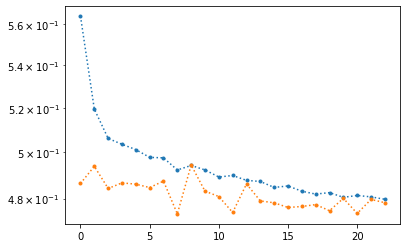

In [17]:
plt.plot(clf.history.history["loss"], ".:")
plt.plot(clf.history.history["val_loss"], ".:")
plt.yscale("log")

In [18]:
pred_y_tr = (
    clf.predict(X_tr)
    .argmax(1)
)

pred_y_ts = (
    clf.predict(X_ts)
    .argmax(1)
)

In [19]:
cr = classification_report(y_tr.argmax(1), pred_y_tr)
print(cr)

cm = pd.DataFrame(
    confusion_matrix(y_tr.argmax(1), pred_y_tr), 
    columns=tuple(zip(["pred"]*3,[0,1,2])), 
    index=tuple(zip(["true"]*3,[0,1,2]))
)
cm.style.background_gradient()

              precision    recall  f1-score   support

           0       0.64      0.85      0.73      6896
           1       0.65      0.38      0.48      2647
           2       0.65      0.35      0.46      2699

    accuracy                           0.64     12242
   macro avg       0.65      0.53      0.55     12242
weighted avg       0.64      0.64      0.61     12242



In [20]:
cr = classification_report(y_ts.argmax(1), pred_y_ts)
print(cr)

cm = pd.DataFrame(
    confusion_matrix(y_ts.argmax(1), pred_y_ts),
    columns=tuple(zip(["pred"]*3,range(3))), 
    index=tuple(zip(["true"]*3,range(3)))
)
cm.style.background_gradient()

              precision    recall  f1-score   support

           0       0.67      0.83      0.74      7277
           1       0.61      0.39      0.48      2581
           2       0.58      0.37      0.45      2383

    accuracy                           0.65     12241
   macro avg       0.62      0.53      0.56     12241
weighted avg       0.64      0.65      0.63     12241



# Visualize

- Green markers for True signal
- Yellow markers for Pred signal

# Train Series

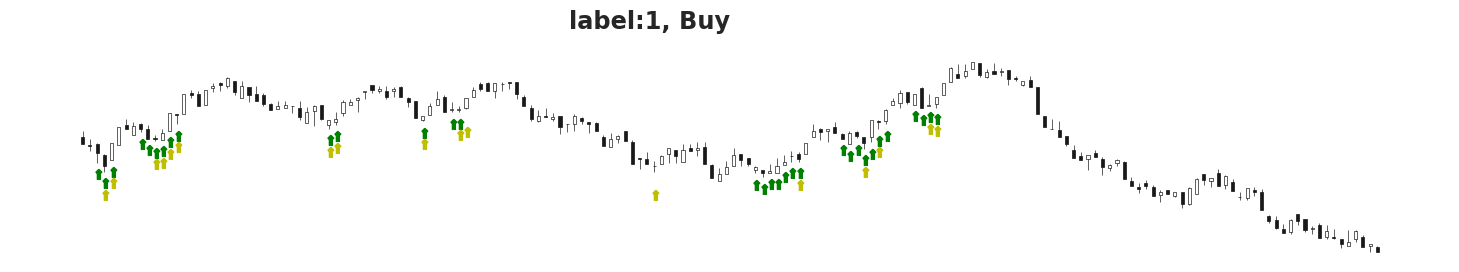

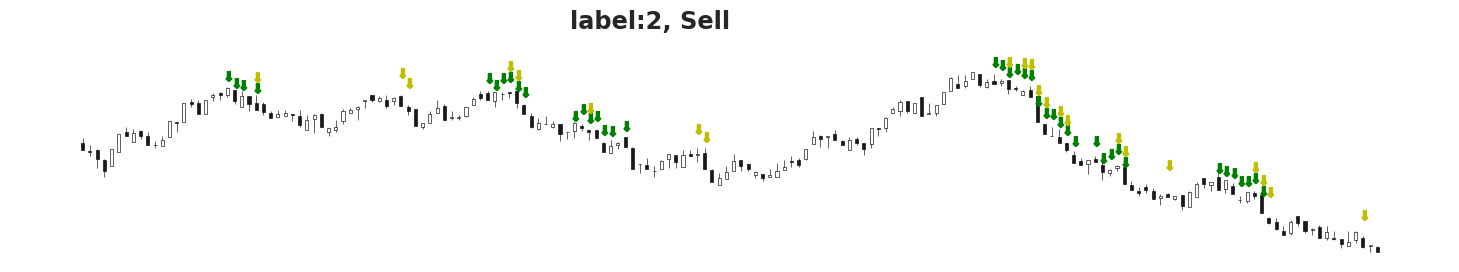

In [21]:
cols = ["open","high","low","close"]

win = 180

np.random.shuffle(train_idx)

for i in train_idx:
    data = data_df[cols].iloc[i:(i+win)]
    h_buy_sig = data["low"].copy() - 10
    h_buy_sig[data_df["h_labels"].iloc[i:(i+win)]!=1] = np.nan
    # print(h_buy_sig)
    
    h_buy_pred = pred_y_tr[i:(i+win)].copy().astype(np.float32)
    h_buy_pred[h_buy_pred==1] = data["low"].iloc[h_buy_pred==1] - 20
    h_buy_pred[h_buy_pred==0] = np.nan
    h_buy_pred[h_buy_pred==2] = np.nan
    
    
    adp = [
        mplf.make_addplot(
            h_buy_sig,
            scatter=True,
            markersize=50, marker=r'$\Uparrow$', color="g"
        ),
        mplf.make_addplot(
            h_buy_pred,
            scatter=True,
            markersize=50, marker=r'$\Uparrow$', color="y"
        )
    ]
    
    mplf.plot(
        data,
        title="label:1, Buy",
        type="candle",
        figsize=(20,3),
        addplot=adp,
        axisoff=True
    )
    plt.show()
    
    data = data_df[cols].iloc[i:(i+win)]
    h_buy_sig = data["low"].copy() + 20
    h_buy_sig[data_df["h_labels"].iloc[i:(i+win)]!=2] = np.nan
    # print(h_buy_sig)
    
    h_buy_pred = pred_y_tr[i:(i+win)].copy().astype(np.float32)
    h_buy_pred[h_buy_pred==2] = data["low"].iloc[h_buy_pred==2] + 30
    h_buy_pred[h_buy_pred==0] = np.nan
    h_buy_pred[h_buy_pred==1] = np.nan
    
    
    adp = [
        mplf.make_addplot(
            h_buy_sig,
            scatter=True,
            markersize=50, marker=r'$\Downarrow$', color="g"
        ),
        mplf.make_addplot(
            h_buy_pred,
            scatter=True,
            markersize=50, marker=r'$\Downarrow$', color="y"
        )
    ]
    
    mplf.plot(
        data,
        title="label:2, Sell",
        type="candle",
        figsize=(20,3),
        addplot=adp,
        axisoff=True
    )
    plt.show()
    
    
    break

# Test Series

In [22]:
test_start_idx = test_idx[0]
test_start_idx

12242

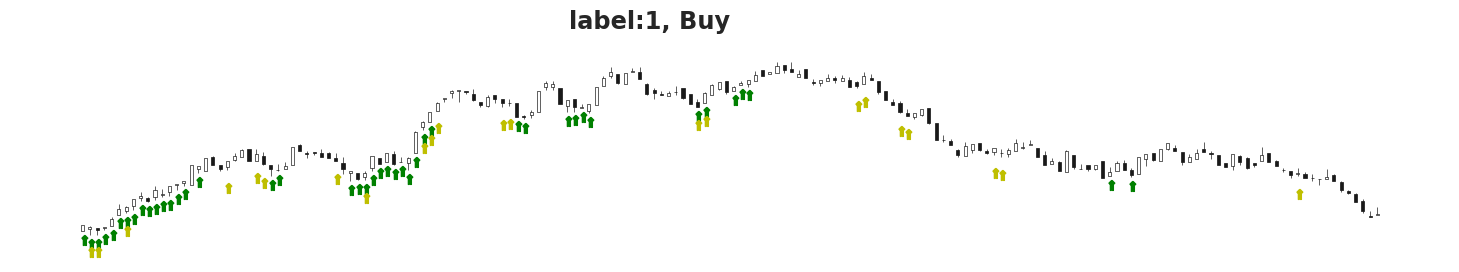

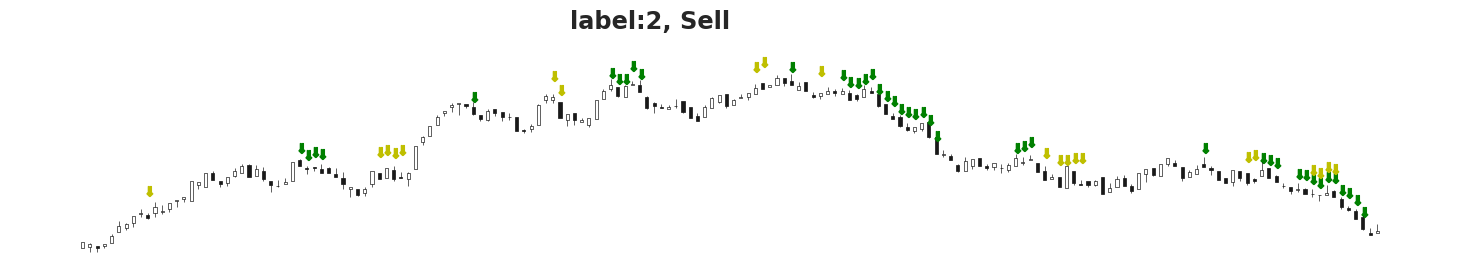

In [23]:
cols = ["open","high","low","close"]

win = 180

np.random.shuffle(test_idx)

for i in test_idx:
    data = data_df[cols].iloc[i:(i+win)]
    h_buy_sig = data["low"].copy() - 10
    h_buy_sig[data_df["h_labels"].iloc[i:(i+win)]!=1] = np.nan
    # print(h_buy_sig)
    
    h_buy_pred = pred_y_tr[(i-test_start_idx):((i-test_start_idx)+win)].copy().astype(np.float32)
    h_buy_pred[h_buy_pred==1] = data["low"].iloc[h_buy_pred==1] - 20
    h_buy_pred[h_buy_pred==0] = np.nan
    h_buy_pred[h_buy_pred==2] = np.nan
    
    
    
    adp = [
        mplf.make_addplot(
            h_buy_sig,
            scatter=True,
            markersize=50, marker=r'$\Uparrow$', color="g"
        ),
        mplf.make_addplot(
            h_buy_pred,
            scatter=True,
            markersize=50, marker=r'$\Uparrow$', color="y"
        )
    ]
    
    mplf.plot(
        data,
        title="label:1, Buy",
        type="candle",
        figsize=(20,3),
        addplot=adp,
        axisoff=True
    )
    
    plt.show()
    
    data = data_df[cols].iloc[i:(i+win)]
    h_buy_sig = data["low"].copy() + 20
    h_buy_sig[data_df["h_labels"].iloc[i:(i+win)]!=2] = np.nan
    # print(h_buy_sig)
    
    h_buy_pred = pred_y_tr[(i-test_start_idx):((i-test_start_idx)+win)].copy().astype(np.float32)
    h_buy_pred[h_buy_pred==2] = data["low"].iloc[h_buy_pred==2] + 30
    h_buy_pred[h_buy_pred==0] = np.nan
    h_buy_pred[h_buy_pred==1] = np.nan
    
    
    
    adp = [
        mplf.make_addplot(
            h_buy_sig,
            scatter=True,
            markersize=50, marker=r'$\Downarrow$', color="g"
        ),
        mplf.make_addplot(
            h_buy_pred,
            scatter=True,
            markersize=50, marker=r'$\Downarrow$', color="y"
        )
    ]
    
    mplf.plot(
        data,
        title="label:2, Sell",
        type="candle",
        figsize=(20,3),
        addplot=adp,
        axisoff=True
    )
    
    plt.show()
    break